# Boltzmann Machine for Movie Recommendation System
During this project, we will use the [dataset](https://grouplens.org/datasets/movielens/latest/) of 600 users and 9000 movies with 100000 ratings from Grouplens for a binary movie recommendation system. The designed Restricted Boltzmann Machine will determine if the user will like the recommended movie or not. 

## Getting the data

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import torch
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor') # To use GPU on pytorch
    cuda_config = True

In [2]:
# Download the files
!wget -q "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
!unzip ml-latest-small.zip
!del ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [3]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv').drop(columns = ['timestamp'])

In [4]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [5]:
ratings.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
8,1,151,5.0
9,1,157,5.0


## Restricted Boltzman Machine Algorithm
Constrastive divergence algorithm [[1]](https://link.springer.com/content/pdf/10.1007/978-3-642-33275-3_2.pdf) has been applied to the RBM object given below.
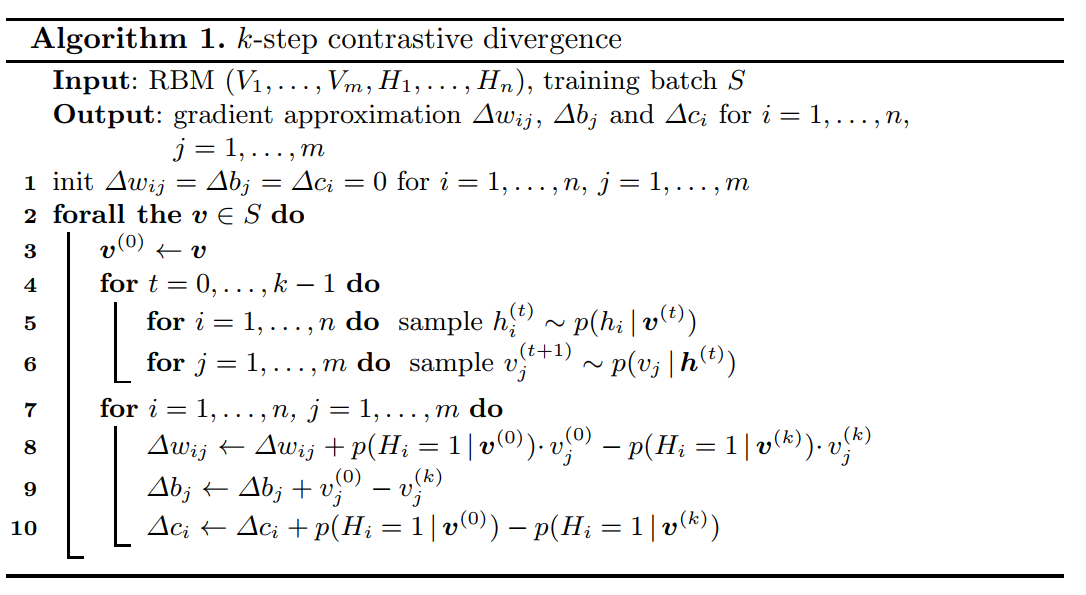

In [6]:
class RBM(object):
    def __init__(self, dataset, batch_size: int = 100, epochs: int = 10):
        
        self.df = dataset.copy(deep = True)
        self.batch_size = batch_size
        self.epochs = epochs
        self.__config = False
        # Split the data
        self.training_set = self.df.iloc[:int(self.df.shape[0] * 0.8), :].values.astype(dtype = np.int64)
        self.test_set = self.df.iloc[int(self.df.shape[0] * 0.8):, :].values.astype(dtype = np.int64)
        # Get the number of users and movies
        self.nb_users = max(self.df['userId'])
        self.nb_movies = max(self.df['movieId'])
    
    # Data processing functions    
    def __transform_data(self, data):
        new_data = []
        for user_id in range(1, self.nb_users + 1):
            id_movies = data[:, 1][data[:, 0] == user_id]
            id_ratings = data[:, 2][data[:, 0] == user_id]
            user_ratings = np.zeros(self.nb_movies)
            user_ratings[id_movies - 1] = id_ratings
            new_data.append(list(user_ratings))
        if cuda_config:
            return torch.cuda.FloatTensor(new_data)
        else:
            return torch.FloatTensor(new_data)
    
    def __binarize(self, data):
        """
        Binarization of Tensor data as
        Not Liked (0) for ratings smaller than 3,
        Liked (1) for ratings equal or greater than 3,
        Non-existing ratings are labeled as (-1).
        """
        data[data == 0] = -1
        data[data == 1] = 0
        data[data == 2] = 0
        data[data >= 3] = 1
        return data
    
    def __prepare_data(self):
        self.training_set = self.__binarize(self.__transform_data(self.training_set))
        self.test_set = self.__binarize(self.__transform_data(self.test_set))
    
    # Contrastive Divergence algorithm
    def __define(self):
        """
        Initializes the weights and biases of RBM model
        """
        # Determine number of nodes
        nv = len(self.training_set[0]) # of visible nodes
        nh = 100 # of hidden nodes
        # Define Weights and biases of RBM
        self.W = torch.randn((nh, nv)) # Weights
        self.a = torch.randn((1, nh)) # Bias of hidden nodes
        self.b = torch.randn((1, nv)) # Bias of visible nodes
        
    def __sample_h(self, x):
        """
        x : visible node for P(h = 1 | v)
        Returns the probability of hidden nodes given the visible ones
        and a sampling distribution according to that probability.
        """
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    
    def __sample_v(self, y):
        """
        y : hidden node for P(v = 1 | h)
        Returns the probability of visible nodes given the hidden ones
        and a sampling distribution according to that probability.
        """
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    
    def __train(self, v0, vk, ph0, phk):
        """
        v0 : Input vector of ratings of user,
        vk : Visible nodes obtained after k iterations,
        ph0 : Vector of probabilities of P(h = 1 | v0)
        phk : Vector of probabilities of P(h = 1 | vk)
        """
        self.W = self.W + (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
        self.b = self.b + torch.sum((v0 - vk), 0)
        self.a = self.a + torch.sum((ph0 - phk), 0)
    
    ## Training the RBM
    def run_training(self):
        self.__prepare_data()
        self.__define()
        for e in range(1, self.epochs + 1):
            train_loss, counter = 0, 0.0
            for id_user in range(0, self.nb_users - self.batch_size, self.batch_size):
                vk = self.training_set[id_user:id_user + self.batch_size]
                v0 = self.training_set[id_user:id_user + self.batch_size]
                ph0, _ = self.__sample_h(v0)
                
                for k in range(10):
                    _, hk = self.__sample_h(vk)
                    _, vk = self.__sample_v(hk)
                    vk[v0 < 0] = v0[v0 < 0]
                phk, _ = self.__sample_h(vk)
                
                # Train the model
                self.__train(v0, vk, ph0, phk)
                train_loss = train_loss + torch.mean(torch.abs(v0[v0 >= 0] - vk[v0 >= 0]))
                counter = counter + 1.0
                
            print("Epoch: {} | Train loss: {:.3f}".format(e, train_loss / counter))
        self.__config = True
    
    def run_testing(self):
        assert self.__config, 'Train the model with run_training() first!'
        test_loss, counter = 0, 0.0
        for id_user in range(self.nb_users):
            v = self.training_set[id_user:id_user + 1]
            vt = self.test_set[id_user:id_user + 1]
            if len(vt[vt >= 0]):
                _, h = self.__sample_h(v)
                _, v = self.__sample_v(h)
                test_loss = test_loss + torch.mean(torch.abs(vt[vt >= 0] - v[vt >= 0]))
                counter = counter + 1.0
        print('Test loss: {:.3f}'.format(test_loss / counter))
        self.__config = False

In [7]:
# Build the RBM model with Ratings data
model = RBM(ratings)
model.run_training()

Epoch: 1 | Train loss: 0.381
Epoch: 2 | Train loss: 0.258
Epoch: 3 | Train loss: 0.239
Epoch: 4 | Train loss: 0.235
Epoch: 5 | Train loss: 0.231
Epoch: 6 | Train loss: 0.232
Epoch: 7 | Train loss: 0.228
Epoch: 8 | Train loss: 0.226
Epoch: 9 | Train loss: 0.224
Epoch: 10 | Train loss: 0.222


In [8]:
# Check the RBM Model on test values
model.run_testing()

Test loss: 0.224
